In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import random
import json
import torch
from isometry_pursuit.vendor import HParams
from isometry_pursuit.atomic_geometry import get_atoms3_full, get_atoms4_full, get_atoms_4
import itertools

print('Loading ethanol data')

config_path = "/Users/samsonkoelle/montlake/experiments/configs/ethanol_full.json"
raw_data = "/Users/samsonkoelle/thesis_data/raw_data/ethanol.mat"

positions = np.load('/Users/samsonkoelle/positions.npy')
randomindices = np.load('/Users/samsonkoelle/indices.npy')

np.random.seed(1234)
random.seed(1234)

config = {}

with open(config_path) as f:
    config.update(json.load(f))

hparams = HParams(**config)

Loading ethanol data


In [2]:
d = hparams.d
n_components = hparams.n_components
atoms2_feat = hparams.atoms2_feat
atoms3_feat = hparams.atoms3_feat
atoms4_feat = hparams.atoms4_feat
atoms2_dict = hparams.atoms2_dict
atoms3_dict = hparams.atoms3_dict
atoms4_dict = hparams.atoms4_dict
diagram = hparams.diagram

ii = np.asarray(hparams.ii)
jj = np.asarray(hparams.jj)
#load geometric features
natoms = positions.shape[1]
n = positions.shape[0]
atoms2 = np.asarray(list(itertools.combinations(range(natoms), 2)))
atoms2full = atoms2
atoms3 = np.asarray(list(itertools.combinations(range(natoms), 3)))
atoms4 = np.asarray(list(itertools.combinations(range(natoms), 4)))
atoms3full = get_atoms3_full(atoms3)
atoms4full = get_atoms4_full(atoms4)

if atoms2_feat:
    atoms2_feats = atoms2full
else:
    atoms2_feats = np.asarray([])

if atoms3_feat:
    atoms3_feats = atoms3full
else:
    atoms3_feats = np.asarray([])

if atoms4_feat:
    atoms4_feats = atoms4full
else:
    atoms4_feats = np.asarray([])

In [3]:
data = np.load('/Users/samsonkoelle/ethanolanglesfull_0524.npy')
n_neighbors = hparams.n_neighbors
atoms4_dicts= get_atoms_4(natoms, ii, jj)[0]
if atoms2_dict:
    atoms2_dicts = atoms2full
else:
    atoms2_dicts = np.asarray([])
if atoms3_dict:
    atoms3_dicts = atoms3full
else:
    atoms3_dicts = np.asarray([])


In [4]:
from scipy import sparse
from isometry_pursuit.transformation import exponential_transformation
from isometry_pursuit.manifold import local_pca
from isometry_pursuit.atomic_geometry import get_D_feats_feats

nsel = 100
dimension = 2
p = atoms4full.shape[0]

selected_points = np.random.choice(range(50000),nsel)
dg_x = np.asarray([get_D_feats_feats(positions[selected_points[i]],
           atoms2in = atoms2_feats,
           atoms3in = atoms3_feats,
           atoms4in = atoms4_feats,
           atoms2out = atoms2_dicts,
           atoms3out = atoms3_dicts,
           atoms4out = atoms4full) for i in range(nsel)])                           

power = 1


/Users/samsonkoelle/miniconda3/envs/isometry/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [5]:
dg_M = np.zeros((nsel, dimension, p))
for i, sp in enumerate(selected_points):
    tangent_bases = local_pca(data, sp, n_neighbors, dimension)
    # NOTE (Sam): normalization prior to projection once again in the manifold case.
    dg_x_normalized = exponential_transformation(dg_x[i], power)
    dg_M[i] = np.einsum('b p, b d -> d p', dg_x_normalized, tangent_bases)

In [6]:
from isometry_pursuit.experiment import analyze_data
from tqdm import tqdm
import pandas as pd

In [21]:
D = 2

losses = []
support_cardinalities_basis_pursuit = []
two_stage_losses = []
random_two_stage_losses = []
greedy_multitask_norms_two_stage = []
brute_isometry_losses = []
brute_losses = []
basis_pursuit_times = []
greedy_times = []
stage_two_times = []

for i in tqdm(range(1)):
    np.random.seed(i)
    random.seed(i)
    (
        loss,
        support_cardinality_basis_pursuit,
        two_stage_loss,
        random_two_stage_loss,
        greedy_multitask_norm_two_stage,
        brute_loss,
        brute_isometry_loss,
        basis_pursuit_time,
        stage_two_time,
        greedy_time,
    ) = analyze_data(dg_M[i], compute_brute=False, power=1.0)
    losses.append(loss)
    if support_cardinality_basis_pursuit > 100:
        break
    support_cardinalities_basis_pursuit.append(support_cardinality_basis_pursuit)
    two_stage_losses.append(two_stage_loss)
    greedy_multitask_norms_two_stage.append(greedy_multitask_norm_two_stage)
    random_two_stage_losses.append(random_two_stage_loss)
    brute_losses.append(brute_loss)
    brute_isometry_losses.append(brute_isometry_loss)
    basis_pursuit_times.append(basis_pursuit_time)
    greedy_times.append(greedy_time)
    stage_two_times.append(stage_two_time)
    results_df = pd.DataFrame(
        {
            "Losses": losses,
            "Support Cardinalities (Basis Pursuit)": support_cardinalities_basis_pursuit,
            "Two-Stage Losses": two_stage_losses,
            "Random Two-Stage Losses": random_two_stage_losses,
            "Greedy Multitask Norms (Two-Stage)": greedy_multitask_norms_two_stage,
            "Brute Isometry Losses": brute_isometry_losses,
            "Brute Losses": brute_losses,
            "Basis Pursuit Times": basis_pursuit_times,
            "Stage Two Times": stage_two_times,
            "Greedy Times": greedy_times,
        }
    )

  0%|                                                                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]/Users/samsonkoelle/isometry-pursuit/isometry_pursuit/loss.py:14: RuntimeWarning: overflow encountered in exp
  (np.exp(singular_values) + np.exp(singular_values ** (-1))) / (2 * np.e)
/Users/samsonkoelle/isometry-pursuit/isometry_pursuit/transformation.py:27: RuntimeWarning: overflow encountered in exp
  exp_values = ((np.exp(norms) + np.exp(norms ** (-1))) ** (-1)) * 2 * np.e


greedy []
greedy [210]
greedy [210, 346]


/Users/samsonkoelle/miniconda3/envs/isometry/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Brute force complexity 3 from D=2 and nbp=3
Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 8473.34it/s]


Computing brute force solution for dictionary dimension 3 and target_dimension 2



3it [00:00, 7593.79it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.08s/it]

stage two time 0.003365039825439453
greedy time 0.05985689163208008
basis pursuit time 9.009654998779297


In [22]:
# results_df.to_csv('/Users/samsonkoelle/isometry-pursuit/experiments/ethanol_results.csv', index = None)

In [24]:
??analyze_data

In [28]:
import cvxpy as cp

def group_basis_pursuit(
    matrix,
    eps=1e-12,
    threshold=1e-6,
    max_iters = 2500,
    seed = 0,
    target = None,
):

    D,P = matrix.shape
    if target is None:
        target = np.identity(D)
#     target[0,1] = 2
    np.random.seed(seed)
    initialization = np.random.randn(P, D)
#     print(initialization)
#     beta = cp.Variable((P, D), value=initialization)  # Random initialization
    beta = cp.Variable((P,D))  # could initialize with lasso?
#     beta.value = np.asarray([[1.,0], [0,1.],[0,0],[0,0]])
    objective = cp.Minimize(cp.sum(cp.norm(beta, axis=1)))
    constraints = [matrix @ beta == target]
    problem = cp.Problem(objective, constraints)
    scs_opts = {"eps": eps, "max_iters": max_iters, "scale": 10.}
    output = problem.solve(solver=cp.SCS, **scs_opts)
#     output = problem.solve(solver = cp.ECOS)
    if output is np.inf:
        raise ValueError("No solution found")
    beta_optimized = beta.value
    beta_sparse = beta_optimized.copy()
    beta_sparse[np.abs(beta_sparse) < threshold] = 0
    return beta_sparse


In [29]:
X = dg_M[i]
power = 1.
data_transformed = exponential_transformation(X, power=power)
beta = group_basis_pursuit(data_transformed)
basis_pursuit_indices = np.where(np.linalg.norm(beta, axis=1))[0]


In [34]:
beta[basis_pursuit_indices]

array([[-0.07803632, -1.01198904],
       [-1.12165392,  0.15848778],
       [-0.00345325, -0.0301979 ]])

In [30]:
# analyze_data(dg_M[i], compute_brute=False, power=1.0)[1]

In [13]:
??analyze_data

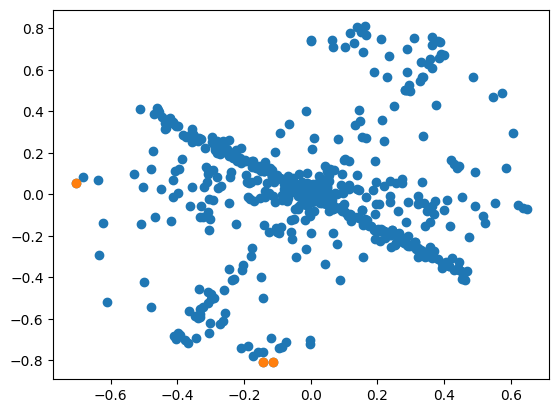

In [32]:
import matplotlib.pyplot as plt
plt.scatter(dg_M[i][0],dg_M[i][1] )
plt.scatter(dg_M[i][0][basis_pursuit_indices],dg_M[i][1][basis_pursuit_indices])

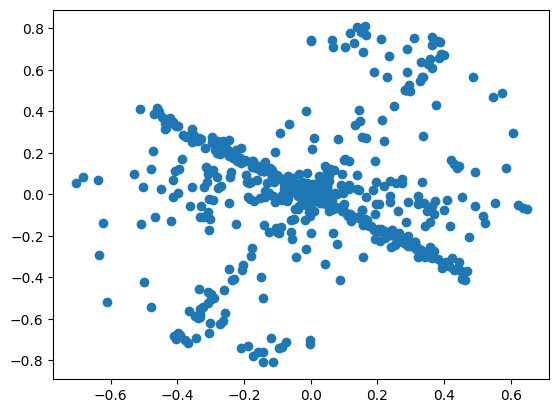

In [19]:
import matplotlib.pyplot as plt
plt.scatter(dg_M[0][0],dg_M[0][1] )

In [20]:
support_cardinalities_basis_pursuit

[3, 3, 3, 3, 3]